In [49]:
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf
import matplotlib.pyplot as plt

## Preprocessing images

#### Loading previous dataset

In [106]:
sample_data_limit = 200

all_data = pd.read_csv("sample_data.csv")
positives = all_data.query('label > 0').head(sample_data_limit).values
negatives = all_data.query("label < 1").head(sample_data_limit).values


#### Resize images to (105, 105) and scale from 0-255 to 0-1

In [57]:
# function to convert image to (105, 105)
def preprocess(image_path):
    byte_image = tf.io.read_file(image_path)
#     print(byte_image)
    img = tf.io.decode_jpeg(byte_image)
#     print(img)
#     plt.imshow(img)
    img = tf.image.resize(img, (105, 105))

    img = img / 255.0 
#     plt.imshow(img)
    #     plt.n
    return img 

In [126]:
mixed_data = np.concatenate((positives, negatives))

for i in range(len(mixed_data)):
# change anchor image and image
    mixed_data[i][1] = preprocess(mixed_data[i][1])
    mixed_data[i][2] = preprocess(mixed_data[i][2])
    
np.random.shuffle(mixed_data)

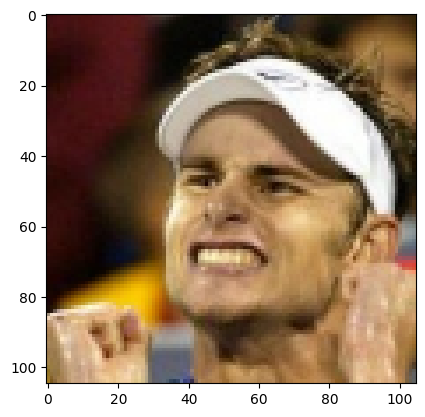

In [131]:
plt.imshow(mixed_data[0][2])

### Train and Test Split

In [160]:
split_ratio = 0.7
# train_data = mixed_data[:(int(len(mixed_data)*split_ratio))]
# train_data = train_data.batch(16)
# test_data = mixed_data[-(int(len(mixed_data)*(1 - split_ratio))):]

# data = tf.data.Dataset.from_tensor_slices(mixed_data)

image_tensors = mixed_data[:, 1:-1]
labels = mixed_data[:, -1]

image_tensors[0][0][0][0]

# image_dataset = tf.data.Dataset.from_tensor_slices(image_tensors)
# label_dataset = tf.data.Dataset.from_tensor_slices(labels)

# dataset = tf.data.Dataset.zip((image_dataset, label_dataset))

# dataset



<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.        , 0.00513539, 0.        ], dtype=float32)>

## Building Model

#### Making Embedding Layer

In [138]:
def make_embedding(): 
    inp = Input(shape=(105,105,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 21, 21, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 18, 18, 128)       26

#### Making Distance Layer

In [139]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [140]:
l1 = L1Dist()

In [141]:
# test distance calculation
anchor_embedding = embedding(mixed_data[0][1][1])

ValueError: Input 0 of layer "embedding" is incompatible with the layer: expected shape=(None, 105, 105, 3), found shape=(105, 3)